In [7]:
from model import load_model
from image_utils import imagenet_utils
import cv2 ,matplotlib.pyplot as plt

In [8]:
orig_img,img=imagenet_utils.load_test_img()

In [9]:
img.shape

(1, 224, 224, 3)

In [10]:
test=load_model('VGG16')

In [11]:
model=test.model
input_dim=test.input_dim
layer_name='block5_conv3'

In [28]:
from explanation_models import gradcam,gradcam_robust,gradcam_plusplus,guided_backprop

# GradCAM

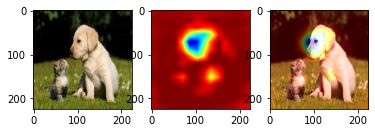

In [7]:
g= gradcam(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM Robust - average

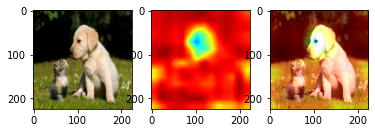

In [8]:
layers=['block5_conv1','block5_conv2','block5_conv3']
g_robust= gradcam_robust(model,layers,input_dim,'GradCAMpp')
heatmap=g_robust.get_heatmap(img)
final=(heatmap[0]+heatmap[1]+heatmap[2])/3.0
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,final)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM Robust - max

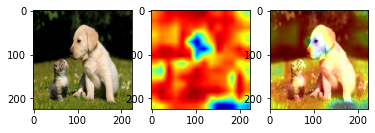

In [9]:
import tensorflow as tf
final=tf.math.maximum(heatmap[0],heatmap[1],heatmap[2])
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,final)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM++

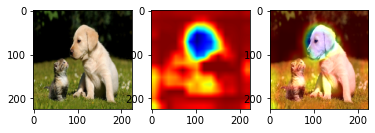

In [10]:
g= gradcam_plusplus(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,heatmap)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# Guided Backprop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


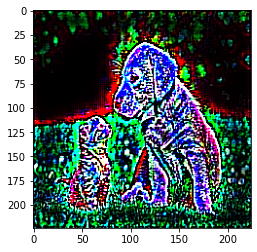

In [11]:
g= guided_backprop(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
plt.imshow(heatmap)

# Using GradCAM to identify adveserial attacks 
## FGSM implimentation from : https://www.tensorflow.org/tutorials/generative/adversarial_fgsm 

In [22]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# image_path='dog.jpg'

image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

# decode_predictions = tf.keras.applications.vgg16.decode_predictions
model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

image = preprocess(image)
image_probs = model.predict(image)
loss_object = tf.keras.losses.CategoricalCrossentropy()



def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

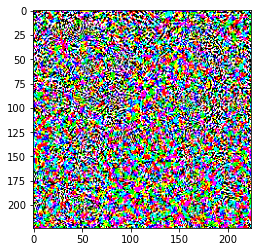

In [23]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0]*0.5+0.5); # To change [-1, 1] to [0,1]

In [24]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

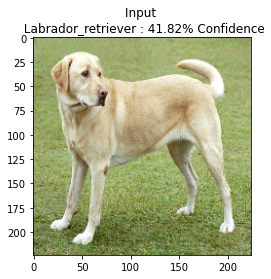

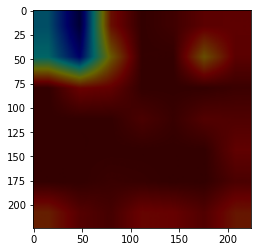

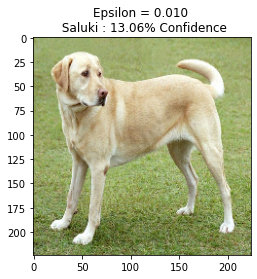

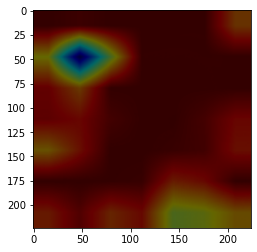

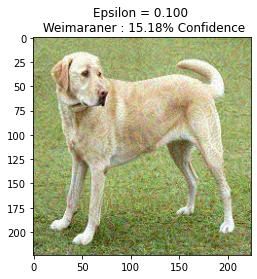

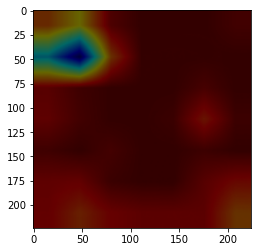

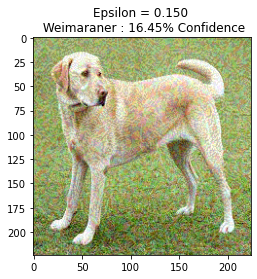

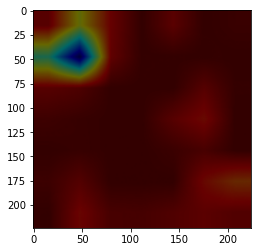

In [48]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])
    g= gradcam(model,'block_16_expand_relu',(224,224))
    heatmap=g.get_heatmap(adv_x)
    heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(adv_x[0],heatmap)
    plt.imshow(overlayed_img)